In [107]:
import math as m
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.cluster import KMeans

In [108]:
indice_lib_eco = pd.read_csv('./csv/indice_lib_eco.csv', header = 0, index_col=0)
indice_idh = pd.read_csv('./csv/indice_idh_porAno.csv', header = 0, index_col=0)
indice_gni = pd.read_csv('./csv/indice_gni_porAno.csv', header = 0, index_col=0)
indice_lib_eco.head()

year ISO_code  countries  index   rank  1_size_government  \
0  2016      DZA    Algeria   4.99  159.0           3.616782   
1  2016      AGO     Angola   5.17  155.0           6.496685   
2  2016      ARG  Argentina   4.84  160.0           5.346056   
3  2016      ARM    Armenia   7.57   29.0           7.003310   
4  2016      AUS  Australia   7.98   10.0           6.544178   

   2_property_rights  3_sound_money   4_trade  5_regulation  
0           4.690743       7.253894  4.127025      5.268992  
1           2.963635       5.606605  5.264754      5.518500  
2           3.904030       5.614336  3.982547      5.369019  
3           5.809215       9.521940  8.143241      7.378069  
4           7.919019       9.452540  7.526721      8.465526

In [109]:
#Fazendo aglutinação das tabelas e retirando as colunas em branco que não possuem em comum
indice_aglutinado = pd.merge(left=indice_lib_eco, right=indice_idh, how='left', left_on=['ISO_code','year'], right_on=['alpha-3','Year'])
indice_aglutinado = pd.merge(left=indice_aglutinado, right=indice_gni, how='left', left_on=['ISO_code','year'], right_on=['alpha-3','Year'])
indice_aglutinado.dropna(subset = ['IDH'], inplace=True)
indice_aglutinado.dropna(subset = ['gni'], inplace=True)

indice_aglutinado = indice_aglutinado[['year','ISO_code','countries','index', 'IDH', 'gni', '1_size_government', '2_property_rights','3_sound_money','4_trade','5_regulation']].copy()
indice_aglutinado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2264 entries, 0 to 2604
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               2264 non-null   int64  
 1   ISO_code           2264 non-null   object 
 2   countries          2264 non-null   object 
 3   index              2264 non-null   float64
 4   IDH                2264 non-null   float64
 5   gni                2264 non-null   float64
 6   1_size_government  2264 non-null   float64
 7   2_property_rights  2264 non-null   float64
 8   3_sound_money      2264 non-null   float64
 9   4_trade            2264 non-null   float64
 10  5_regulation       2264 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 194.6+ KB


In [126]:
indice_aglutinado.describe()

year        index          IDH            gni  \
count  2264.000000  2264.000000  2264.000000    2264.000000   
mean   2007.063163     6.796126     0.696638   18653.443905   
std       6.368350     0.929249     0.161950   19187.381283   
min    1990.000000     3.280000     0.210000     666.000000   
25%    2003.000000     6.190000     0.584750    4278.750000   
50%    2008.000000     6.910000     0.721000   11628.500000   
75%    2012.000000     7.460000     0.831000   28129.250000   
max    2016.000000     9.190000     0.951000  114214.000000   

       1_size_government  2_property_rights  3_sound_money      4_trade  \
count        2264.000000        2264.000000    2264.000000  2264.000000   
mean            6.413156           5.467376       8.089667     7.136039   
std             1.348425           1.726271       1.457623     1.263803   
min             2.362745           1.463109       2.386633     1.781689   
25%             5.456287           4.220251       7.007516     6.387319   
50%             6.494444           5.376186       8.395827     7.263531   
75%             7.404996           6.504894       9.399719     8.049111   
max             9.904651           9.278333       9.922187     9.970370   

       5_regulation  
count   2264.000000  
mean       6.880673  
std        1.066860  
min        3.044655  
25%        6.254944  
50%        6.917401  
75%        7.615950  
max        9.439828

In [110]:
#Correlacionando o dataset
#Esta correlação vai sair um pouco diferente da última
#Pois dropamos mais algumas linhas que não tinham informações em comum entre as tabelas aglutinadas
correlacoes = indice_aglutinado.corr()
print(correlacoes)

                       year     index       IDH       gni  1_size_government  \
year               1.000000  0.154129  0.161816  0.063533           0.117703   
index              0.154129  1.000000  0.686535  0.564038           0.176934   
IDH                0.161816  0.686535  1.000000  0.733035          -0.226417   
gni                0.063533  0.564038  0.733035  1.000000          -0.265961   
1_size_government  0.117703  0.176934 -0.226417 -0.265961           1.000000   
2_property_rights -0.040635  0.761667  0.747728  0.652516          -0.295793   
3_sound_money      0.194186  0.800114  0.572586  0.460347          -0.052296   
4_trade            0.060217  0.855534  0.653201  0.522240          -0.005925   
5_regulation       0.247159  0.779715  0.503461  0.485674           0.061050   

                   2_property_rights  3_sound_money   4_trade  5_regulation  
year                       -0.040635       0.194186  0.060217      0.247159  
index                       0.761667       

<AxesSubplot:xlabel='index', ylabel='IDH'>

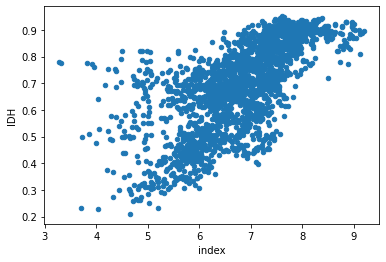

In [111]:
#Verificando a dispersão entre ILE e IDH
indice_aglutinado.plot.scatter('index', 'IDH')

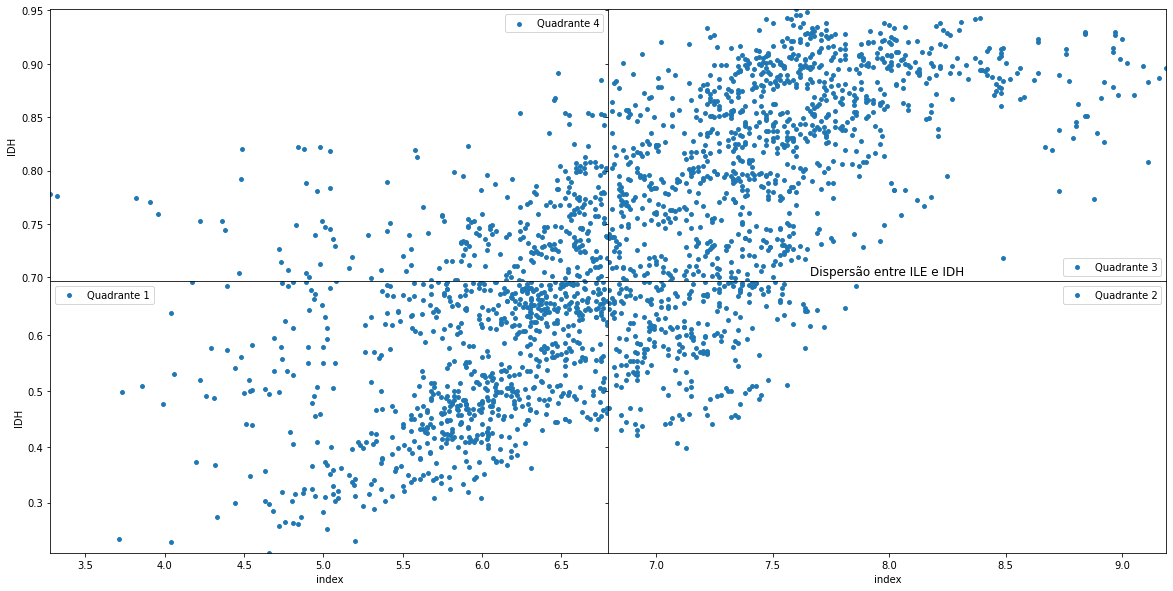

In [129]:
#Informações para montar quadrantes
eco = indice_aglutinado['index']
idh = indice_aglutinado['IDH']

media_eco = eco.mean()
media_idh = idh.mean()

min_eco = eco.min()
max_eco = eco.max()
min_idh = idh.min()
max_idh = idh.max()

# Eco e IDH abaixo da média
quadrante1 = ( eco < media_eco ) & ( idh < media_idh )
# Eco acima da média e IDH abaixo da média
quadrante2 = ( eco > media_eco ) & ( idh < media_idh )
# Eco e IDH acima da média
quadrante3 = ( eco > media_eco ) & ( idh > media_idh )
# Eco abaixo da média e IDH acima da média
quadrante4 = ( eco < media_eco ) & ( idh > media_idh )

fig, ax = plt.subplots(2, 2, figsize=(20,10), sharex='col', sharey='row')
plt.subplots_adjust(wspace=0, hspace=0)
plt.title('Dispersão entre ILE e IDH')

df1 = indice_aglutinado[quadrante1]
df1.plot.scatter('index', 'IDH', s=15, ax = ax[1,0], xlim = (min_eco, media_eco), ylim = (min_idh, media_idh))
ax[1,0].legend(['Quadrante 1'])

df2 = indice_aglutinado[quadrante2]
df2.plot.scatter('index', 'IDH', s=15, ax = ax[1,1], xlim = (media_eco, max_eco), ylim = (min_idh, media_idh))
ax[1,1].legend(['Quadrante 2'])

df3 = indice_aglutinado[quadrante3]
df3.plot.scatter('index', 'IDH', s=15, ax = ax[0,1], xlim = (media_eco, max_eco), ylim = (media_idh, max_idh))
ax[0,1].legend(['Quadrante 3'])

df4 = indice_aglutinado[quadrante4]
df4.plot.scatter('index', 'IDH', s=15, ax = ax[0,0], xlim = (min_eco, media_eco), ylim = (media_idh, max_idh))
ax[0,0].legend(['Quadrante 4'])

In [113]:
print('{}% quadrante 1'.format(100*len(df1) / len(indice_aglutinado)))
print('{}% quadrante 2'.format(100*len(df2) / len(indice_aglutinado)))
print('{}% quadrante 3'.format(100*len(df3) / len(indice_aglutinado)))
print('{}% quadrante 4'.format(100*len(df4) / len(indice_aglutinado)))

32.95053003533569% quadrante 1
11.484098939929329% quadrante 2
43.68374558303887% quadrante 3
11.881625441696112% quadrante 4


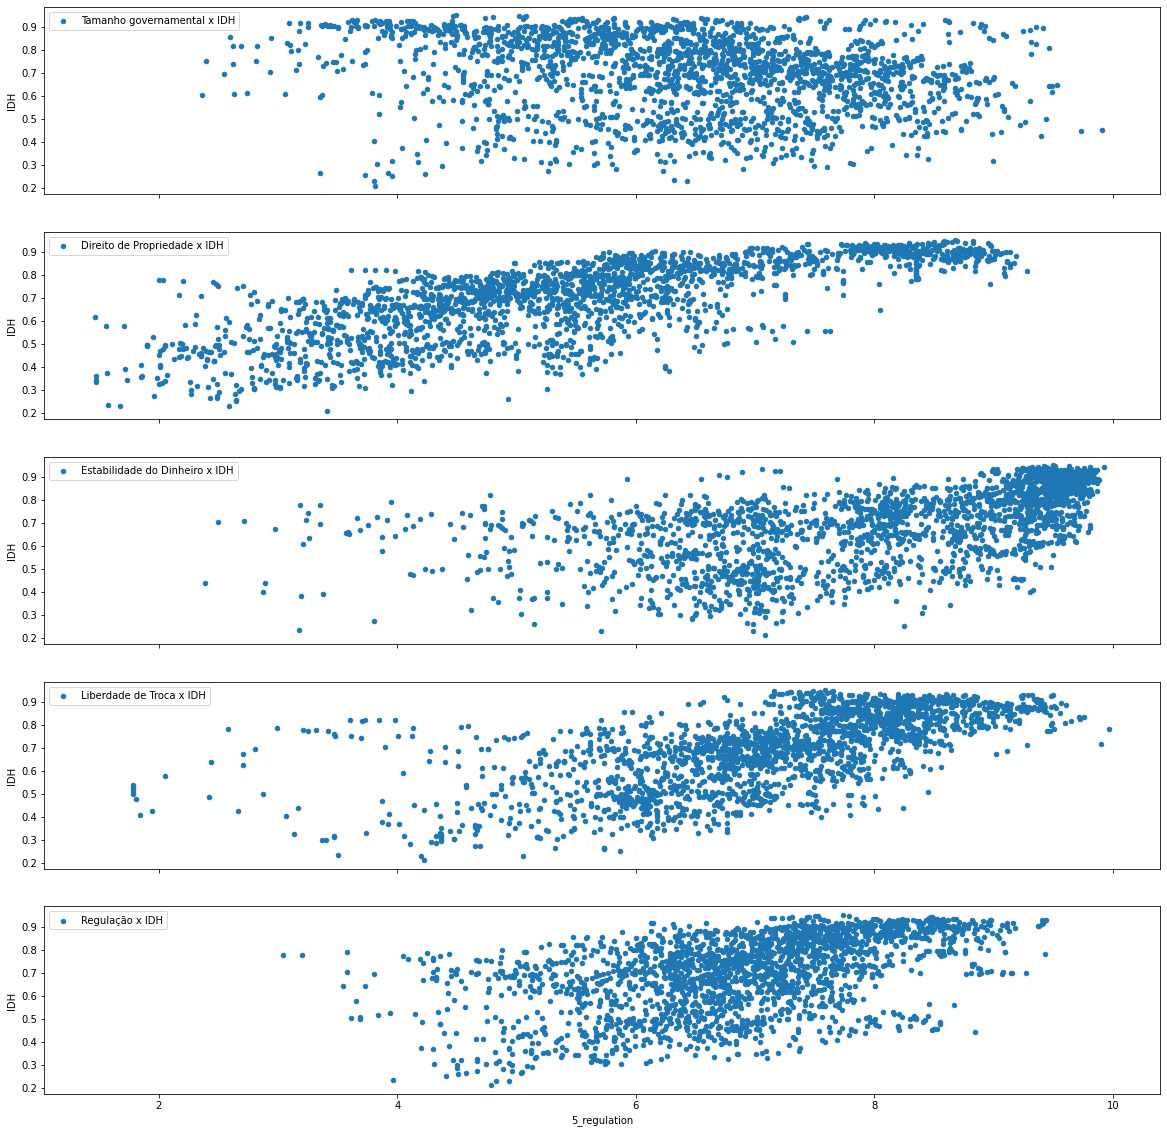

In [130]:
# '1_size_government', '2_property_rights','3_sound_money','4_trade','5_regulation'
fig, ax = plt.subplots(5,1, figsize=(20,20), sharex='col')
indice_aglutinado.plot.scatter('1_size_government', 'IDH', ax=ax[0])
ax[0].legend(['Tamanho governamental x IDH'])
indice_aglutinado.plot.scatter('2_property_rights', 'IDH', ax=ax[1])
ax[1].legend(['Direito de Propriedade x IDH'])
indice_aglutinado.plot.scatter('3_sound_money', 'IDH', ax=ax[2])
ax[2].legend(['Estabilidade da Moeda x IDH'])
indice_aglutinado.plot.scatter('4_trade', 'IDH', ax=ax[3])
ax[3].legend(['Liberdade de Troca x IDH'])
indice_aglutinado.plot.scatter('5_regulation', 'IDH', ax=ax[4])
ax[4].legend(['Regulação x IDH'])

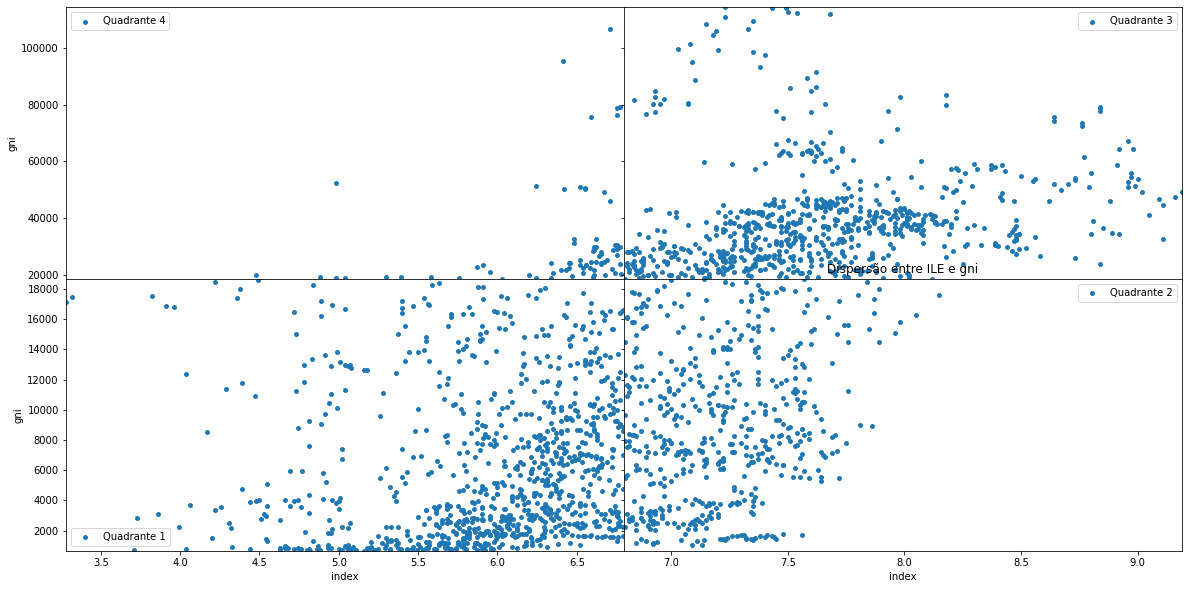

In [134]:
#Informações para montar quadrantes
eco = indice_aglutinado['index']
gni = indice_aglutinado['gni']

media_eco = eco.mean()
media_gni = gni.mean()

min_eco = eco.min()
max_eco = eco.max()
min_gni = gni.min()
max_gni = gni.max()

# Eco e gni abaixo da média
quadrante1 = ( eco < media_eco ) & ( gni < media_gni )
# Eco acima da média e gni abaixo da média
quadrante2 = ( eco > media_eco ) & ( gni < media_gni )
# Eco e gni acima da média
quadrante3 = ( eco > media_eco ) & ( gni > media_gni )
# Eco abaixo da média e gni acima da média
quadrante4 = ( eco < media_eco ) & ( gni > media_gni )

fig, ax = plt.subplots(2, 2, figsize=(20,10), sharex='col', sharey='row')
plt.subplots_adjust(wspace=0, hspace=0)
plt.title('Dispersão entre ILE e gni')

df1 = indice_aglutinado[quadrante1]
df1.plot.scatter('index', 'gni', s=15, ax = ax[1,0], xlim = (min_eco, media_eco), ylim = (min_gni, media_gni))
ax[1,0].legend(['Quadrante 1'])

df2 = indice_aglutinado[quadrante2]
df2.plot.scatter('index', 'gni', s=15, ax = ax[1,1], xlim = (media_eco, max_eco), ylim = (min_gni, media_gni))
ax[1,1].legend(['Quadrante 2'])

df3 = indice_aglutinado[quadrante3]
df3.plot.scatter('index', 'gni', s=15, ax = ax[0,1], xlim = (media_eco, max_eco), ylim = (media_gni, max_gni))
ax[0,1].legend(['Quadrante 3'])

df4 = indice_aglutinado[quadrante4]
df4.plot.scatter('index', 'gni', s=15, ax = ax[0,0], xlim = (min_eco, media_eco), ylim = (media_gni, max_gni))
ax[0,0].legend(['Quadrante 4'])

In [135]:
print('{}% quadrante 1'.format(100*len(df1) / len(indice_aglutinado)))
print('{}% quadrante 2'.format(100*len(df2) / len(indice_aglutinado)))
print('{}% quadrante 3'.format(100*len(df3) / len(indice_aglutinado)))
print('{}% quadrante 4'.format(100*len(df4) / len(indice_aglutinado)))

41.51943462897526% quadrante 1
22.39399293286219% quadrante 2
32.773851590106005% quadrante 3
3.312720848056537% quadrante 4


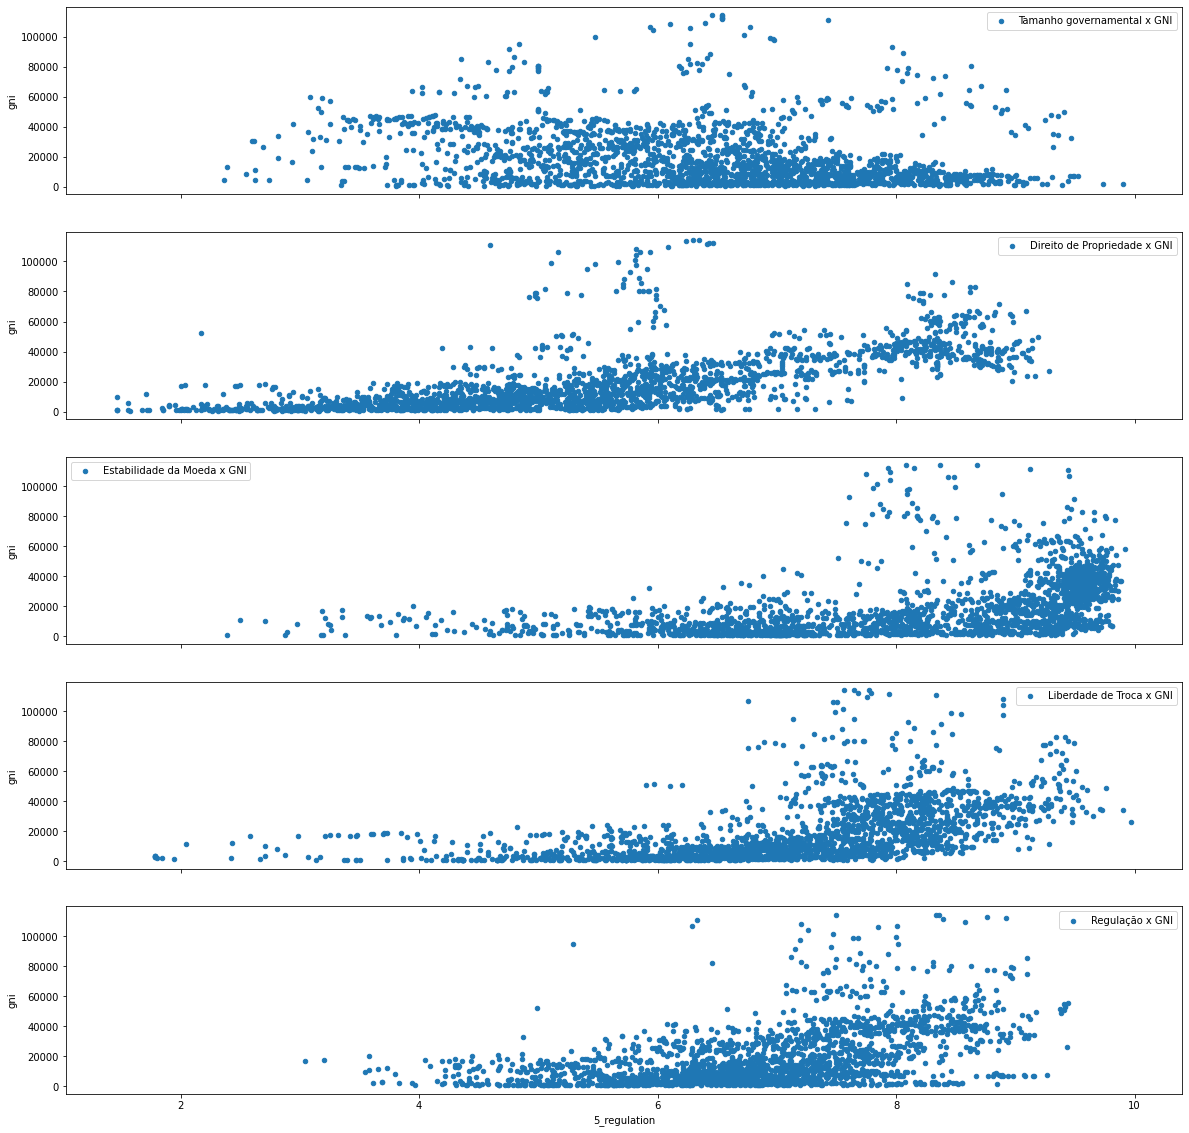

In [137]:
# '1_size_government', '2_property_rights','3_sound_money','4_trade','5_regulation'
fig, ax = plt.subplots(5,1, figsize=(20,20), sharex='col')
indice_aglutinado.plot.scatter('1_size_government', 'gni', ax=ax[0])
ax[0].legend(['Tamanho governamental x GNI'])
indice_aglutinado.plot.scatter('2_property_rights', 'gni', ax=ax[1])
ax[1].legend(['Direito de Propriedade x GNI'])
indice_aglutinado.plot.scatter('3_sound_money', 'gni', ax=ax[2])
ax[2].legend(['Estabilidade da Moeda x GNI'])
indice_aglutinado.plot.scatter('4_trade', 'gni', ax=ax[3])
ax[3].legend(['Liberdade de Troca x GNI'])
indice_aglutinado.plot.scatter('5_regulation', 'gni', ax=ax[4])
ax[4].legend(['Regulação x GNI'])

<AxesSubplot:xlabel='index', ylabel='gni'>

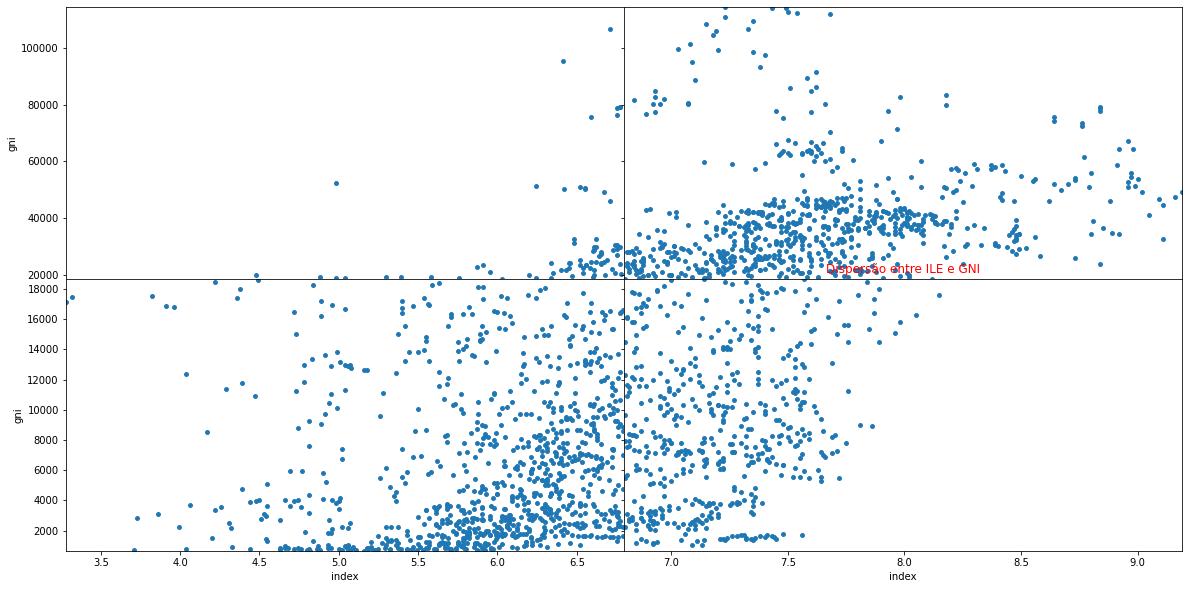

In [116]:
#Informações para montar quadrantes
eco = indice_aglutinado['index']
gni = indice_aglutinado['gni']

media_eco = eco.mean()
media_gni = gni.mean()

min_eco = eco.min()
max_eco = eco.max()
min_gni = gni.min()
max_gni = gni.max()

# Eco e IDH abaixo da média
quadrante1 = ( eco < media_eco ) & ( gni < media_gni )
# Eco acima da média e gni abaixo da média
quadrante2 = ( eco > media_eco ) & ( gni < media_gni )
# Eco e gni acima da média
quadrante3 = ( eco > media_eco ) & ( gni > media_gni )
# Eco abaixo da média e gni acima da média
quadrante4 = ( eco < media_eco ) & ( gni > media_gni )

fig, ax = plt.subplots(2, 2, figsize=(20,10), sharex='col', sharey='row')
plt.subplots_adjust(wspace=0, hspace=0)
plt.title('Dispersão entre ILE e GNI', c='red')

df1 = indice_aglutinado[quadrante1]
df1.plot.scatter('index', 'gni', s=15, ax = ax[1,0], xlim = (min_eco, media_eco), ylim = (min_gni, media_gni))

df2 = indice_aglutinado[quadrante2]
df2.plot.scatter('index', 'gni', s=15, ax = ax[1,1], xlim = (media_eco, max_eco), ylim = (min_gni, media_gni))

df3 = indice_aglutinado[quadrante3]
df3.plot.scatter('index', 'gni', s=15, ax = ax[0,1], xlim = (media_eco, max_eco), ylim = (media_gni, max_gni))

df4 = indice_aglutinado[quadrante4]
df4.plot.scatter('index', 'gni', s=15, ax = ax[0,0], xlim = (min_eco, media_eco), ylim = (media_gni, max_gni))

In [117]:
print('{}% quadrante 1'.format(100*len(df1) / len(indice_aglutinado)))
print('{}% quadrante 2'.format(100*len(df2) / len(indice_aglutinado)))
print('{}% quadrante 3'.format(100*len(df3) / len(indice_aglutinado)))
print('{}% quadrante 4'.format(100*len(df4) / len(indice_aglutinado)))

41.51943462897526% quadrante 1
22.39399293286219% quadrante 2
32.773851590106005% quadrante 3
3.312720848056537% quadrante 4


In [118]:
#Montando DF com as informações que iremos tentar capturar apenas pelo k-means
indice_aglutinado_simples = indice_aglutinado

indice_aglutinado_simples = indice_aglutinado[['index', 'IDH', '1_size_government', '2_property_rights','3_sound_money','4_trade','5_regulation']].copy()
indice_aglutinado_simples["IDH"] = indice_aglutinado_simples["IDH"] * 10

indice_aglutinado_simples

index   IDH  1_size_government  2_property_rights  3_sound_money  \
0      4.99  7.53           3.616782           4.690743       7.253894   
2      4.84  8.22           5.346056           3.904030       5.614336   
3      7.57  7.49           7.003310           5.809215       9.521940   
4      7.98  9.38           6.544178           7.919019       9.452540   
5      7.58  9.06           5.086295           7.915987       9.432830   
...     ...   ...                ...                ...            ...   
2600   8.18  7.75           5.648982           7.734517       9.477608   
2601   8.48  8.60           6.958432           8.346500       9.675165   
2602   6.60  6.92           7.674767           6.275098       3.757000   
2603   5.55  6.34           5.951632           5.699114       4.735508   
2604   4.94  4.91           5.570864           3.703770       5.667952   

       4_trade  5_regulation  
0     4.127025      5.268992  
2     3.982547      5.369019  
3     8.143241      7.378069  
4     7.526721      8.465526  
5     8.106733      7.371334  
...        ...           ...  
2600  9.471111      8.585715  
2601  8.742222      8.660963  
2602  8.645185      6.625178  
2603  6.405926      4.933183  
2604  4.902963      4.870138  

[2264 rows x 7 columns]

In [119]:
indice_aglutinado_simples.isnull().sum()

index                0
IDH                  0
1_size_government    0
2_property_rights    0
3_sound_money        0
4_trade              0
5_regulation         0
dtype: int64

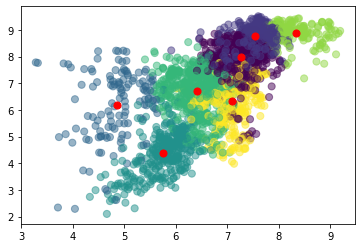

In [120]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(indice_aglutinado_simples)
centroids = kmeans.cluster_centers_


plt.scatter(indice_aglutinado_simples['index'], indice_aglutinado_simples['IDH'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

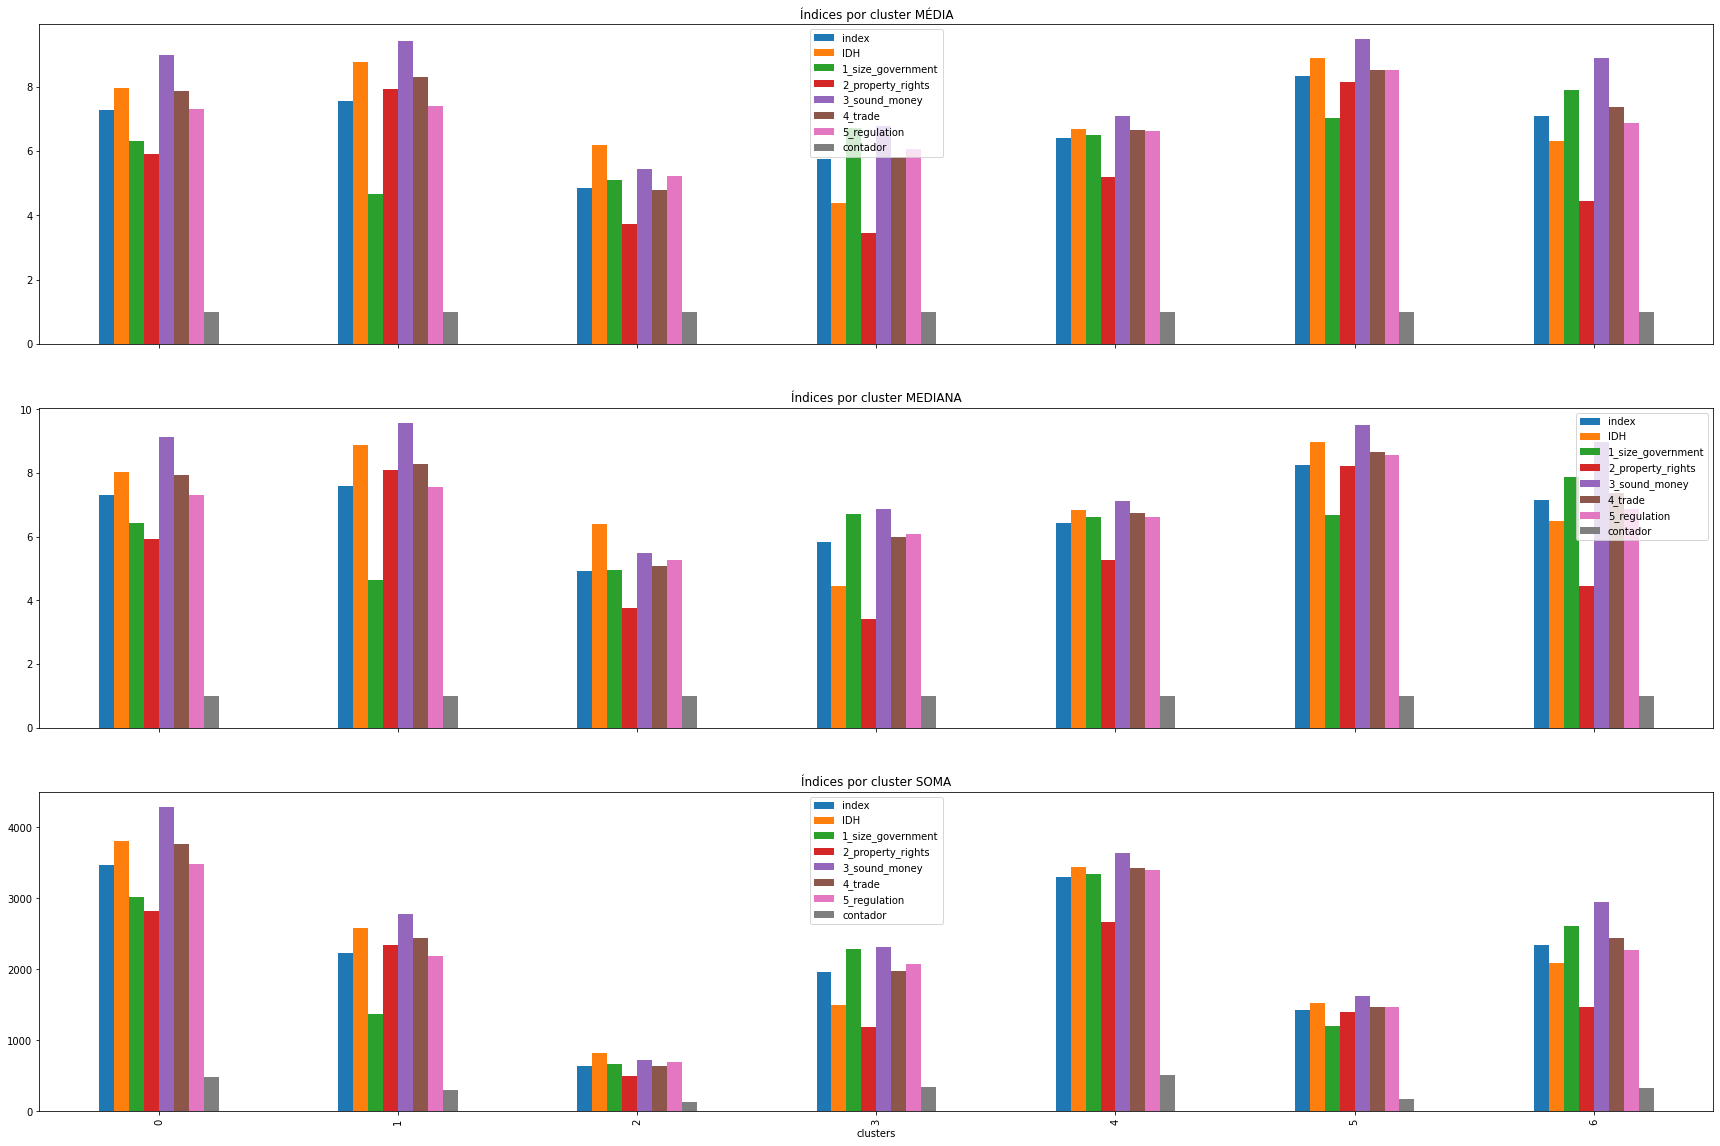

In [125]:
indice_aglutinado_comparacao = indice_aglutinado[['index', 'IDH', '1_size_government', '2_property_rights','3_sound_money','4_trade','5_regulation']].copy()
indice_aglutinado_comparacao["IDH"] = indice_aglutinado_comparacao["IDH"] * 10
indice_aglutinado_comparacao["clusters"] = kmeans.fit_predict(indice_aglutinado_simples.values)
indice_aglutinado_comparacao["contador"] = 1

fig, ax = plt.subplots(3, 1, figsize=(30,20), sharex='col', sharey='row')

indice_aglutinado_comparacao.groupby("clusters").aggregate("mean").plot.bar(ax=ax[0])
ax[0].title.set_text("Índices por cluster MÉDIA")

indice_aglutinado_comparacao.groupby("clusters").median().plot.bar(ax=ax[1])
ax[1].title.set_text("Índices por cluster MEDIANA")

indice_aglutinado_comparacao.groupby("clusters").aggregate("sum").plot.bar(ax=ax[2])
ax[2].title.set_text("Índices por cluster SOMA")

In [123]:
indice_aglutinado[indice_aglutinado_comparacao['clusters'] == 2]

year ISO_code        countries  index    IDH      gni  \
0     2016      DZA          Algeria   4.99  0.753  13832.0   
2     2016      ARG        Argentina   4.84  0.822  18249.0   
34    2016      COG   Congo, Rep. Of   5.02  0.612   6765.0   
68    2016      IRQ             Iraq   5.40  0.672  16387.0   
85    2016      LBY            Libya   4.74  0.693   8799.0   
...    ...      ...              ...    ...    ...      ...   
2590  1990      LKA        Sri Lanka   4.76  0.625   3587.0   
2596  1990      TTO  Trinidad & Tob.   5.50  0.672  10058.0   
2598  1990      TUR           Turkey   4.73  0.579  11214.0   
2603  1990      VEN        Venezuela   5.55  0.634  14529.0   
2604  1990      ZWE         Zimbabwe   4.94  0.491   2693.0   

      1_size_government  2_property_rights  3_sound_money   4_trade  \
0              3.616782           4.690743       7.253894  4.127025   
2              5.346056           3.904030       5.614336  3.982547   
34             5.833377           3.244861       5.603964  4.883225   
68             5.248190           2.774515       7.258295  5.239558   
85             4.750000           3.206339       5.659898  4.763775   
...                 ...                ...            ...       ...   
2590           6.971927           2.314235       5.495763  2.705926   
2596           6.306109           6.106285       5.943265  2.706667   
2598           5.821313           3.977909       3.867214  4.710370   
2603           5.951632           5.699114       4.735508  6.405926   
2604           5.570864           3.703770       5.667952  4.902963   

      5_regulation  
0         5.268992  
2         5.369019  
34        5.551182  
68        6.475280  
85        5.301138  
...            ...  
2590      6.304974  
2596      6.462585  
2598      5.280886  
2603      4.933183  
2604      4.870138  

[132 rows x 11 columns]